# Goal

* Create simple langgraph to convert entrez IDs to SRX accessions

# Init

In [1]:
# import 
import os
import re
import time
import operator
from functools import partial
from enum import Enum
from pprint import pprint
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [2]:
from SRAgent.agents.entrez import create_entrez_agent
from SRAgent.agents.utils import create_step_summary_chain
from SRAgent.tools.convert import geo2sra

In [3]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [4]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [5]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

# State

In [6]:
class YesNo(Enum):
    """
    Yes or no
    """
    YES = "yes"
    NO = "no"
    UNSURE = "unsure"

class Organism(Enum):
    """
    Organism
    """
    HUMAN = "human"
    MOUSE = "mouse"
    RAT = "rat"
    MONKEY = "monkey"
    HORSE = "horse"
    DOG = "dog"
    BOVINE = "bovine"
    CHICKEN = "chicken"
    SHEEP = "sheep"
    PIG = "pig"
    FRUIT_FLY = "fruit_fly"
    ROUNDWORM = "roundworm"
    ZEBRAFISH = "zebrafish"
    OTHER = "other"

class IntAddOperator:
    def __call__(self, x: int, y: int) -> int:
        return x + y

class GraphState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    is_illumina: Annotated[str, "Is Illumina sequence data?"]
    is_single_cell: Annotated[str, "Is single cell RNA-seq data?"]
    is_paired_end: Annotated[str, "Is paired-end sequencing data?"]
    is_10x: Annotated[str, "Is 10X Genomics data?"]
    organism: Annotated[str, "Organism sequenced"]
    route: Annotated[str, "Route"]
    rounds: Annotated[int, operator.add]

# Nodes

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [8]:
metadata_items = [
    " - Is the study Illumina sequence data?",
    " - Is the study Illumina sequence data?",
    " - Is the study single cell RNA-seq data?",
    " - Is the study paired-end sequencing data?",
    " - Is the study 10X Genomics data?",
    " - Which organism was sequenced?"
]

In [9]:
# invoke entrez agent
def invoke_entrez_agent_node(state: GraphState):
    entrez_agent = create_entrez_agent()
    prompt = ChatPromptTemplate.from_messages([
        MessagesPlaceholder(variable_name="history")
    ])
    formatted_prompt = prompt.format_messages(
        history=state["messages"][-4:]
    )
    response = entrez_agent.invoke({"messages" : formatted_prompt})
    return {"messages" : [response["messages"][-1]]}

prompt = "\n".join([
    "For the SRA accession SRX11740066, find the following information:",
    ] + metadata_items
)
state = {"messages" : [HumanMessage(content=prompt)]}
# invoke_entrez_agent_node(state)

In [10]:
class Metadata(BaseModel):
    is_illumina: YesNo
    is_single_cell: YesNo
    is_paired_end: YesNo
    is_10x: YesNo
    organism: Organism

def invoke_get_metadata_node(state: GraphState):
    """
    Structured data extraction
    """
    message = state["messages"][-1].content
    prompt = "\n".join([
        "Your job is to extract metadata from the provided text on a Sequence Read Archive (SRA) experiment.",
        "If there is not enough information to determine the metadata, please respond with 'unsure'.",
        "The specific metadata to extract:"] + metadata_items + [
        "\n",
        "The provided text:",
        message
    ])
    model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    response = model.with_structured_output(Metadata, strict=True).invoke(prompt)
    return {
        "is_illumina" : response.is_illumina.value,
        "is_single_cell" : response.is_single_cell.value,
        "is_paired_end" : response.is_paired_end.value,
        "is_10x" : response.is_10x.value,
        "organism" : response.organism.value
    }

state = {
    "messages" : [
        HumanMessage(
            content=" - Sequencing was performed on an Illumina platform. The data is single cell RNA-seq data. The data is paired-end sequencing data. The data is 10X Genomics data. The organism sequenced is human.",
        )
    ]
}
# invoke_get_metadata_node(state)

In [ ]:
# router
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

class Choices(Enum):
    CONTINUE = "Continue"
    STOP = "Stop"

class Choice(BaseModel):
    Choice: Choices

def invoke_router_node(state: GraphState):
    """
    Router for the graph
    """
    # create prompt
    prompt1 = "\n".join([
        "You determine whether all of appropriate metadata has been extracted.",
        "If most or all of the metadata is \"unsure\", then the task is incomplete."
        ]
    )
    prompt2 = "\n".join([
        "\nThe extracted metadata:",
        " - Is the study Illumina sequence data?",
        "    - " + state['is_illumina'],
        " - Is the study single cell RNA-seq data?",
        "    - " + state['is_single_cell'],
        " - Is the study paired-end sequencing data?",
        "    - " + state['is_paired_end'],
        " - Is the study 10X Genomics data?",
        "    - " + state['is_10x'],
        " - Which organism was sequenced?",
        "    - " + state['organism']
    ])

    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", prompt1),
        ("system", "\nHere are the last few messages:"),
         MessagesPlaceholder(variable_name="history"),
        ("system", prompt2),
        # Add the final question/instruction
        ("human", "Based on the messages above, select STOP if the task is complete or CONTINUE if more information is needed."),
    ])
    formatted_prompt = prompt.format_messages(history=state["messages"][-3:])
    # call the model
    response = model.with_structured_output(Choice, strict=True).invoke(formatted_prompt)
    # format the response
    if response.Choice.value == Choices.CONTINUE.value:
        message = "At least some of the meadata is still uncertain. Please try to provide more information using a different approach."
    else:
        message = "Enough of the metadata has been extracted."
    return {"route": response.Choice.value, "rounds": 1, "messages": [AIMessage(content=message)]}

# Graph

In [12]:
from langgraph.graph import START, END, StateGraph, MessagesState

In [13]:
def route_interpret(state: GraphState) -> str:
    """
    Determine the route based on the current state of the conversation.
    """
    if state["rounds"] >= 2:
        return END
    return "entrez_agent_node" if state["route"] == "Continue" else END
    #return "entrez_agent_node"

In [14]:
#-- graph --#
workflow = StateGraph(GraphState)

# nodes
workflow.add_node("entrez_agent_node", invoke_entrez_agent_node)
workflow.add_node("get_metadata_node", invoke_get_metadata_node)
workflow.add_node("router_node", invoke_router_node)

# edges
workflow.add_edge(START, "entrez_agent_node")
workflow.add_edge("entrez_agent_node", "get_metadata_node")
workflow.add_edge("get_metadata_node", "router_node")
workflow.add_conditional_edges("router_node", route_interpret)

# compile the graph
graph = workflow.compile()

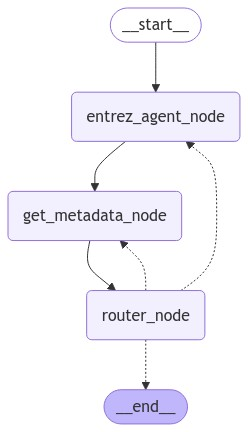

In [15]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [16]:
prompt = "\n".join([
    "For the SRA accession SRX11740066, find the following information:",
    ] + metadata_items
)
input = {"messages" : [HumanMessage(content=prompt)]}
for step in graph.stream(input, config={"max_concurrency" : 3, "recursion_limit": 20}):
    print(step)

{'entrez_agent_node': {'messages': [AIMessage(content='Here is the information for SRA accession SRX11740066:\n\n- **Illumina Sequence Data**: Yes\n- **Single Cell RNA-seq Data**: Not specified\n- **Paired-End Sequencing Data**: Yes\n- **10X Genomics Data**: Not specified\n- **Organism Sequenced**: Homo sapiens (Human)', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 1532, 'total_tokens': 1609, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-30c1b8e7-862c-4a26-8746-f8f8b13ec1b1-0', usage_metadata={'input_tokens': 1532, 'output_tokens': 77, 'total_tokens': 1609, 'input_token_details': {'audio': 0, 'cache_read': 1408}, 'output_token_details